In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
from torch.utils.data import DataLoader

# go from /notebooks → /
PROJECT_ROOT = os.path.abspath("..")
print("PROJECT_ROOT:", PROJECT_ROOT)

# add to python path
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# print("Final sys.path[0]:", sys.path[0])
from src.data.s1hand import S1HandDataset
from src.data.s1weak import S1WeakDataset
from src.data.loaders import make_s1hand_loaders, make_s1weak_loader
from src.data.augmentations import get_train_transform, get_val_transform


DATA_ROOT = os.path.join(PROJECT_ROOT, "data")

PROJECT_ROOT: /Users/sicunchen/coding/CS7643-Group-Proj


# Verify HandLabeled chipcounts

In [2]:
# --- Hand labeled ---
s1hand_dir = os.path.join(DATA_ROOT, "HandLabeled", "S1Hand")
labelhand_dir = os.path.join(DATA_ROOT, "HandLabeled", "LabelHand")

hand_images = sorted([f for f in os.listdir(s1hand_dir) if f.endswith(".tif")])
hand_labels = sorted([f for f in os.listdir(labelhand_dir) if f.endswith(".tif")])

print("Hand-labeled S1Hand images:", len(hand_images))
print("Hand-labeled LabelHand masks:", len(hand_labels))

# Check 1:1 match
missing_labels = []
for f in hand_images:
    stem = f.replace("_S1Hand.tif", "")
    if f"{stem}_LabelHand.tif" not in hand_labels:
        missing_labels.append(f)

print("Missing labels:", missing_labels if missing_labels else "None")

Hand-labeled S1Hand images: 446
Hand-labeled LabelHand masks: 446
Missing labels: None


In [3]:
s1weak_dir = os.path.join(DATA_ROOT, "WeaklyLabeled", "S1Weak")
s1weak_label_dir = os.path.join(DATA_ROOT, "WeaklyLabeled", "S1OtsuLabelWeak")

weak_images = sorted([f for f in os.listdir(s1weak_dir) if f.endswith(".tif")])
weak_labels = sorted([f for f in os.listdir(s1weak_label_dir) if f.endswith(".tif")])

print("Weak S1Weak tiles:", len(weak_images))
print("Weak S1OtsuLabelWeak masks:", len(weak_labels))

# Check 1:1 mapping
missing_otsu = []
for f in weak_images:
    match = f.replace("S1Weak", "S1OtsuLabelWeak")
    if match not in weak_labels:
        missing_otsu.append(f)

print("Missing Otsu masks:", missing_otsu if missing_otsu else "None")

Weak S1Weak tiles: 50
Weak S1OtsuLabelWeak masks: 50
Missing Otsu masks: None


# Visualize a random S1Hand Tile (Correct Mask Cleaning + Overlay)

Selected tile: Sri-Lanka_653336_S1Hand.tif
Image path  : /Users/sicunchen/coding/CS7643-Group-Proj/data/HandLabeled/S1Hand/Sri-Lanka_653336_S1Hand.tif
Mask path   : /Users/sicunchen/coding/CS7643-Group-Proj/data/HandLabeled/LabelHand/Sri-Lanka_653336_LabelHand.tif
Mask unique values: {np.uint8(0): np.int64(244159), np.uint8(1): np.int64(17982), np.uint8(255): np.int64(3)}
Hand mask stats: 6.86% water, 93.14% land


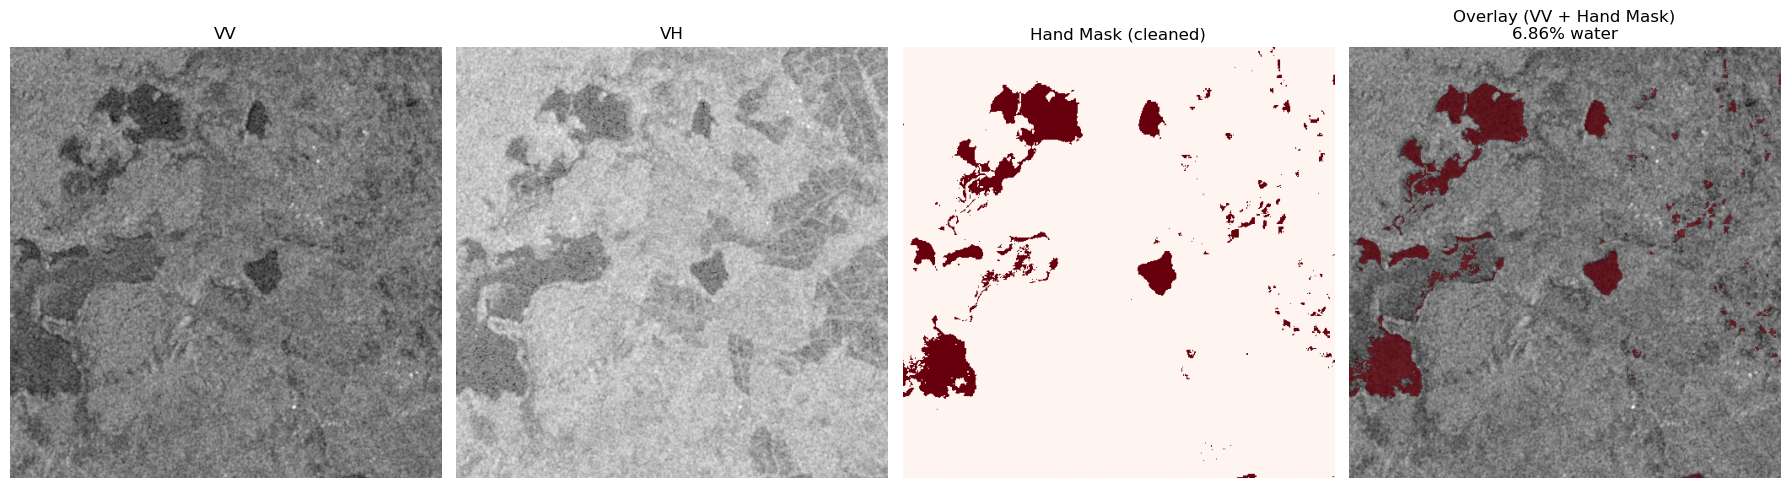

In [12]:
import random
import rasterio
from src.data.io import clean_hand_mask


# -----------------------------
# 1. Pick a random tile
# -----------------------------
all_tiles = sorted([f for f in os.listdir(s1hand_dir) if f.endswith(".tif")])
rand_tile = random.choice(all_tiles)

prefix = rand_tile.replace("_S1Hand.tif", "")
label_name = f"{prefix}_LabelHand.tif"

img_path = os.path.join(s1hand_dir , rand_tile)
mask_path = os.path.join(labelhand_dir, label_name)

print("Selected tile:", rand_tile)
print("Image path  :", img_path)
print("Mask path   :", mask_path)

# -----------------------------
# 2. Load S1 image (VV/VH)
# -----------------------------
with rasterio.open(img_path) as src:
    img = src.read()       # shape: (2, 512, 512)
vv, vh = img[0], img[1]

# -----------------------------
# 3. Load + clean mask
# -----------------------------
with rasterio.open(mask_path) as src:
    raw_mask = src.read(1)

mask = clean_hand_mask(raw_mask)
mask_vis = mask.astype(float)
mask_vis[mask_vis == 255] = np.nan


# Inspect values
vals, counts = np.unique(mask, return_counts=True)
print("Mask unique values:", dict(zip(vals, counts)))

num_water = counts[vals == 1].sum() if np.any(vals == 1) else 0
num_land  = counts[vals == 0].sum() if np.any(vals == 0) else 0
total     = mask.size
print(f"Hand mask stats: {100*num_water/total:.2f}% water, {100*num_land/total:.2f}% land")

# For overlay: show ONLY water pixels (mask==1), ignore 0 and 255
water_only = np.where(mask == 1, 1.0, np.nan)
# -----------------------------
# 4. Plot
# -----------------------------
fig, ax = plt.subplots(1, 4, figsize=(18, 5))

ax[0].imshow(vv, cmap='gray')
ax[0].set_title("VV")

ax[1].imshow(vh, cmap='gray')
ax[1].set_title("VH")

ax[2].imshow(mask_vis, cmap='Reds',vmin=0, vmax=1)
ax[2].set_title("Hand Mask (cleaned)")

# overlay
ax[3].imshow(vv, cmap='gray')
ax[3].imshow(water_only, cmap='Reds',alpha=0.7,vmin=0, vmax=1)
ax[3].set_title(f"Overlay (VV + Hand Mask)\n{100*num_water/total:.2f}% water")

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

# Visualize a random tile from S1Hand

Selected weak tile: Bolivia_6725703_S1Weak.tif
Image path : /Users/sicunchen/coding/CS7643-Group-Proj/data/WeaklyLabeled/S1Weak/Bolivia_6725703_S1Weak.tif
Mask path  : /Users/sicunchen/coding/CS7643-Group-Proj/data/WeaklyLabeled/S1OtsuLabelWeak/Bolivia_6725703_S1OtsuLabelWeak.tif
Mask unique values: {np.uint8(0): np.int64(224462), np.uint8(1): np.int64(37682)}
Weak mask stats: 14.37% water, 85.63% land


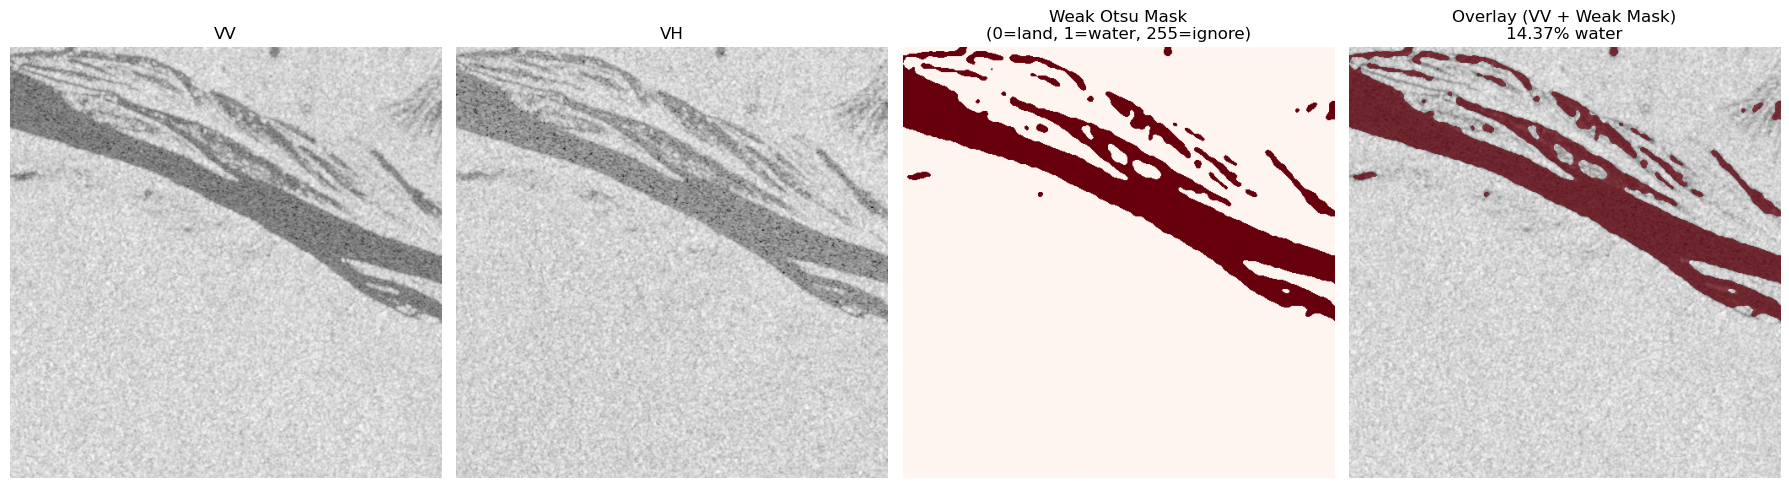

In [15]:
import os, random
import numpy as np
import rasterio
import matplotlib.pyplot as plt

from src.data.io import clean_weak_mask  

# -----------------------------
# 1. Pick a random weak tile
# -----------------------------
all_weak = sorted([f for f in os.listdir(s1weak_dir) if f.endswith(".tif")])
weak_tile = random.choice(all_weak)

prefix = weak_tile.replace("_S1Weak.tif", "")
label_name = f"{prefix}_S1OtsuLabelWeak.tif"

img_path = os.path.join(s1weak_dir, weak_tile)
mask_path = os.path.join(s1weak_label_dir, label_name)

print("Selected weak tile:", weak_tile)
print("Image path :", img_path)
print("Mask path  :", mask_path)

# -----------------------------
# 2. Load S1 image (VV/VH)
# -----------------------------
with rasterio.open(img_path) as src:
    img = src.read()  # (2, H, W)
vv, vh = img[0], img[1]

# -----------------------------
# 3. Load + clean weak mask
# -----------------------------
with rasterio.open(mask_path) as src:
    raw_mask = src.read(1)

mask = clean_weak_mask(raw_mask)  # 0=land, 1=water, 255=ignore
mask_vis = mask.astype(float)
mask_vis[mask_vis == 255] = np.nan
# Inspect values
vals, counts = np.unique(mask, return_counts=True)
print("Mask unique values:", dict(zip(vals, counts)))

num_water = counts[vals == 1].sum() if np.any(vals == 1) else 0
num_land  = counts[vals == 0].sum() if np.any(vals == 0) else 0
total     = mask.size
print(f"Weak mask stats: {100*num_water/total:.2f}% water, {100*num_land/total:.2f}% land")

# -----------------------------
# 4. Prepare overlay: ONLY water pixels
# -----------------------------
# land (0) and ignore (255) become NaN → fully transparent
water_only = np.where(mask == 1, 1.0, np.nan).astype(float)

# -----------------------------
# 5. Plot
# -----------------------------
fig, ax = plt.subplots(1, 4, figsize=(18, 5))

ax[0].imshow(vv, cmap='gray')
ax[0].set_title("VV")

ax[1].imshow(vh, cmap='gray')
ax[1].set_title("VH")

ax[2].imshow(mask_vis, cmap='Reds', vmin=0, vmax=1)
ax[2].set_title("Weak Otsu Mask\n(0=land, 1=water, 255=ignore)")

# Overlay: make water REALLY obvious
ax[3].imshow(vv, cmap='gray')
im = ax[3].imshow(
    water_only,
    cmap='Reds',   
    alpha=0.7,
    vmin=0,
    vmax=1
)
ax[3].set_title(f"Overlay (VV + Weak Mask)\n{100*num_water/total:.2f}% water")

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

# Test loaders


In [6]:
from src.data.loaders import make_s1hand_loaders, make_s1weak_loader
train_loader, val_loader, test_loader = make_s1hand_loaders(
    data_root=DATA_ROOT,
    batch_size=4,
    num_workers=0,
)

weak_loader = make_s1weak_loader(
    data_root=DATA_ROOT,
    batch_size=4,
    num_workers=0,
    max_samples=4,   # small for preview
)

batch = next(iter(train_loader))
imgs, masks = batch

print("Batch image shape:", imgs.shape)   # (B, C, H, W)
print("Batch mask shape:", masks.shape)   # (B, H, W)
print("Mask unique values (batch):", masks.unique())

[S1HandDataset] Loaded 252 pairs (split=train)
[S1HandDataset] Loaded 89 pairs (split=valid)
[S1HandDataset] Loaded 90 pairs (split=test)
[S1WeakDataset] Loaded 4 weak tiles (max_samples=4)
Batch image shape: torch.Size([4, 2, 256, 256])
Batch mask shape: torch.Size([4, 256, 256])
Mask unique values (batch): tensor([  0,   1, 255])


/opt/anaconda3/envs/cs7643-flood/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


# Visualize Augmentation (Before vs After)

2 tiles raw vs augmented

In [27]:
from src.data.augmentations import S1_MEAN, S1_STD
from torch.utils.data import DataLoader

# -----------------------------
# raw dataset: No crops/flips, full 512×512 tile.
# -----------------------------
raw_ds = S1WeakDataset(
    data_root=DATA_ROOT,
    max_samples=2,
    transform=None,
)
# raw_ds = S1HandDataset(
#     data_root=DATA_ROOT,
#     transform=None,
#     split="train",
#     max_samples=2,
# )
raw_loader = DataLoader(raw_ds, batch_size=2, shuffle=False, num_workers=0)

# -----------------------------
# augmented dataset: crop to 256*256, random flip 
# -----------------------------
aug_ds = S1WeakDataset(
    data_root=DATA_ROOT,
    max_samples=2,
    transform=get_train_transform(image_size=256),
)
# aug_ds = S1HandDataset(
#     data_root=DATA_ROOT,
#     transform=get_train_transform(image_size=256),
#     split="train",
#     max_samples=2,
# )
aug_loader = DataLoader(aug_ds, batch_size=2, shuffle=False, num_workers=0)

#raw_imgs are already normalized by normalize_s1. raw_masks are already cleaned (0, 1, 255).
raw_imgs, raw_masks = next(iter(raw_loader))
#cropped/flipped + extra normalization
aug_imgs, aug_masks = next(iter(aug_loader))

# -----------------------------
# Helper: undo Albumentations Normalize
# -----------------------------
def denorm(band, mean, std):
    return np.clip(band * std + mean, 0.0, 1.0)

def denormalize_s1(x_norm):
    return x_norm * 51.0 - 50.0

[S1WeakDataset] Loaded 2 weak tiles (max_samples=2)
[S1WeakDataset] Loaded 2 weak tiles (max_samples=2)


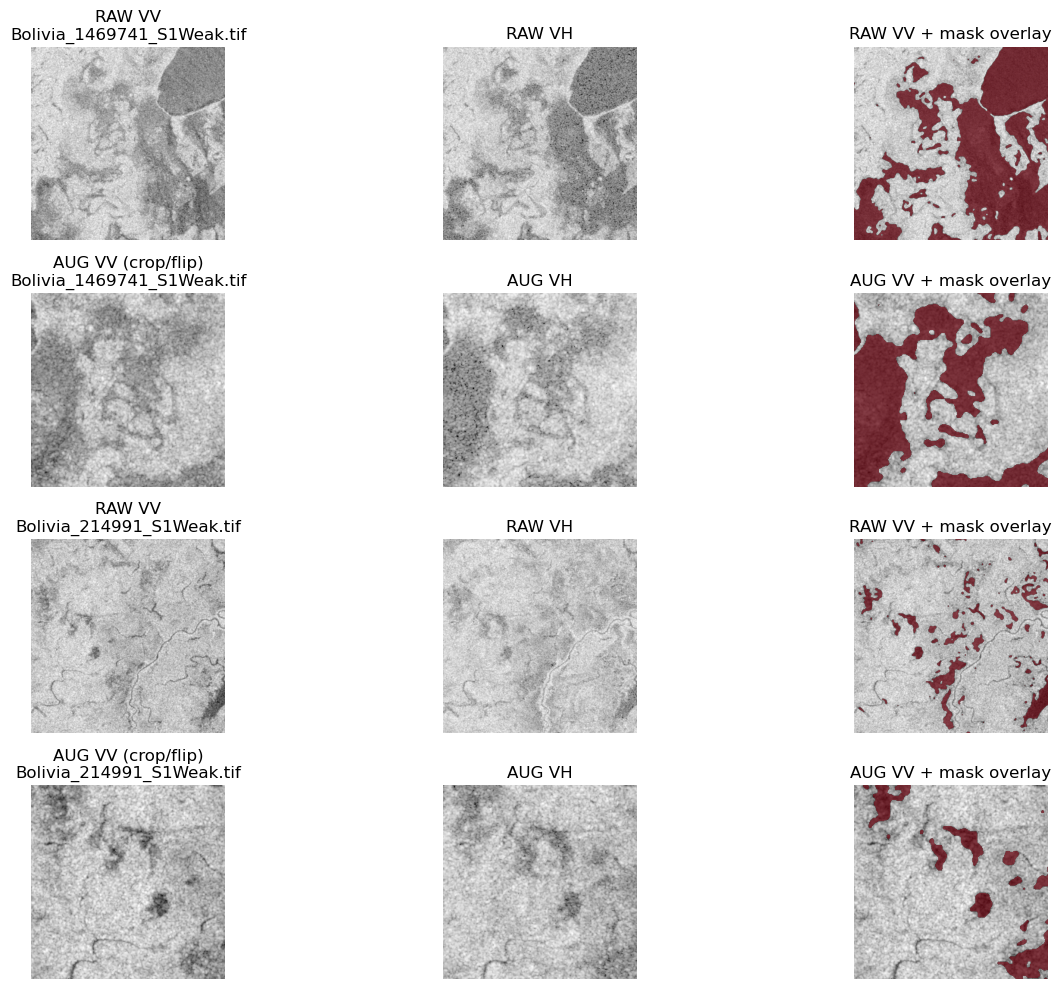

In [28]:
B = raw_imgs.shape[0]
fig, axes = plt.subplots(B * 2, 3, figsize=(14, 5 * B))
for i in range(B):
    img_path, mask_path = raw_ds.samples[i]
    tile_name = os.path.basename(img_path)
    # -------------------------
    # RAW
    # -------------------------
    vv_raw = denormalize_s1(raw_imgs[i, 0].numpy())     # already normalized_s1
    vh_raw = denormalize_s1(raw_imgs[i, 1].numpy())
    mask_raw = raw_masks[i].numpy()
    water_raw = np.where(mask_raw == 1, 1.0, np.nan)

    r_raw = i * 2

    axes[r_raw, 0].imshow(vv_raw, cmap="gray")
    axes[r_raw, 0].set_title(f"RAW VV\n{tile_name}")
    axes[r_raw, 0].axis("off")

    axes[r_raw, 1].imshow(vh_raw, cmap="gray")
    axes[r_raw, 1].set_title("RAW VH")
    axes[r_raw, 1].axis("off")

    axes[r_raw, 2].imshow(vv_raw, cmap="gray")
    axes[r_raw, 2].imshow(water_raw, cmap="Reds", alpha=0.7, vmin=0, vmax=1)
    axes[r_raw, 2].set_title("RAW VV + mask overlay")
    axes[r_raw, 2].axis("off")

    # -------------------------
    # AUG (crop/flip + A.Normalize)
    # -------------------------
    vv_aug = denorm(
        aug_imgs[i, 0].numpy(),
        S1_MEAN[0],
        S1_STD[0],
    )
    vh_aug = denorm(
        aug_imgs[i, 1].numpy(),
        S1_MEAN[1],
        S1_STD[1],
    )
    mask_aug = aug_masks[i].numpy()
    water_aug = np.where(mask_aug == 1, 1.0, np.nan)

    r_aug = i * 2 + 1

    axes[r_aug, 0].imshow(vv_aug, cmap="gray")
    axes[r_aug, 0].set_title(f"AUG VV (crop/flip)\n{tile_name}")
    axes[r_aug, 0].axis("off")

    axes[r_aug, 1].imshow(vh_aug, cmap="gray")
    axes[r_aug, 1].set_title("AUG VH")
    axes[r_aug, 1].axis("off")

    axes[r_aug, 2].imshow(vv_aug, cmap="gray")
    axes[r_aug, 2].imshow(water_aug, cmap="Reds", alpha=0.7, vmin=0, vmax=1)
    axes[r_aug, 2].set_title("AUG VV + mask overlay")
    axes[r_aug, 2].axis("off")

plt.tight_layout()
plt.show()